In [17]:
import tensorflow as tf
from keras.layers import Dense, Input, Dropout
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint,LearningRateScheduler
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import cv2

from time import time, sleep
import os

# Since I am using a dark backgroud. Comment it out if you are using a light theme
plt.style.use(['dark_background'])

#tensorboard --logdir=logs/ --host localhost --port 8088
print(f'Tensorflow Version - {tf.__version__}')
print(f'Keras Version - {tf.keras.__version__}')

Tensorflow Version - 1.12.0
Keras Version - 2.1.6-tf


In [2]:
DATA_DIR = 'data'

In [3]:
def process_data():
    (train,_),(test,_) = mnist.load_data(path =DATA_DIR)
    train = train/255
    test = test/255
    train = train.reshape((len(train), np.prod(train.shape[1:])))
    test = test.reshape((len(test), np.prod(test.shape[1:])))
    print(f'Training Data Shape : {train.shape}')
    print(f'Testing Data Shape  : {test.shape}')
    return train,test
X_train, X_test = process_data()

Training Data Shape : (60000, 784)
Testing Data Shape  : (10000, 784)


In [4]:
def get_models():
    tf.reset_default_graph()
    
    dropout_rate = 0.1
    
    input_layer = Input(shape=(784,),name='input_layer')
    layer = Dense(512,name='encode_1',activation='relu')(input_layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(256,name='encode_2',activation='relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(128,name='encode_3',activation='relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(64,name='encode_4',activation='relu')(layer)
    
    bottleneck_layer = Dense(36,name='bottleneck_layer',activation='relu')(layer)
    
    layer = Dense(64,name='decode_1',activation='relu')(bottleneck_layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(128,name='decode_2',activation='relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(256,name='decode_3',activation='relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(512,name='decode_4',activation='relu')(layer)
    layer = Dropout(dropout_rate)(layer)
    output_layer = Dense(784,name='output_layer',activation='sigmoid')(layer)
    
    
    autoencoder_model = Model(input_layer,output_layer)
    encoder_model = Model(input_layer,bottleneck_layer)
    return autoencoder_model,encoder_model

In [8]:
autoencoder,encoder = get_models()
print('Structure of Autoencoder Model\n')
autoencoder.summary()
print('\n\nStructure of Encoder Model\n')
encoder.summary()

Structure of Autoencoder Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 784)               0         
_________________________________________________________________
encode_1 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
encode_2 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
encode_3 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)    

In [ ]:
BATCH_SIZE = 64
LR = 0.001

adam = Adam(lr=LR)
autoencoder.compile(adam,'binary_crossentropy',metrics=['accuracy'])


def get_scheduled_lr(epoch,lr):
    if epoch ==15:
        return lr*0.2
    elif epoch==25:
        return lr*0.3
    elif epoch==35:
        return lr*0.4
    elif epoch==40:
        return lr*0.5
    return lr

tensoboard = TensorBoard(log_dir='logs\{}'.format(time()),batch_size=BATCH_SIZE,update_freq='epoch')
save_model = ModelCheckpoint(filepath='saved_models/autoencoder-epoch_{epoch}.h5',
                            monitor='loss',verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='loss',factor=0.3,patience=3,verbose=1,min_lr=0.000001)
lr_scheduled = LearningRateScheduler(get_scheduled_lr,verbose=1)

callbacks = [tensoboard,save_model,lr_scheduled]

In [11]:
EPOCHS = 50
hist = autoencoder.fit(X_train,X_train,batch_size=BATCH_SIZE,
                       epochs=EPOCHS,verbose=2,callbacks=callbacks)

In [5]:
def plot_result(original,created):
    shape = int(np.sqrt(original.shape[0]))
    original = np.reshape(original,(shape,shape))
    created = np.reshape(created,(shape,shape))
    
    fig,axs = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True)
    fig.set_size_inches((14,10))
    
    axs[0].set_title("Original Image\n",fontdict = {'fontsize':16})
    axs[0].imshow(original,cmap = 'gray')
    axs[0].set_axis_off()
    
    axs[1].set_title("Constructed Image\n",fontdict = {'fontsize':16})
    axs[1].imshow(created,cmap = 'gray')
    axs[1].set_axis_off()

    plt.show()

In [6]:
def random_result():
    rand_idx = np.random.randint(0,len(X_test))
    plot_result(X_test[rand_idx],autoencoder_prediction[rand_idx])

In [9]:
autoencoder_prediction = autoencoder.predict(X_test)

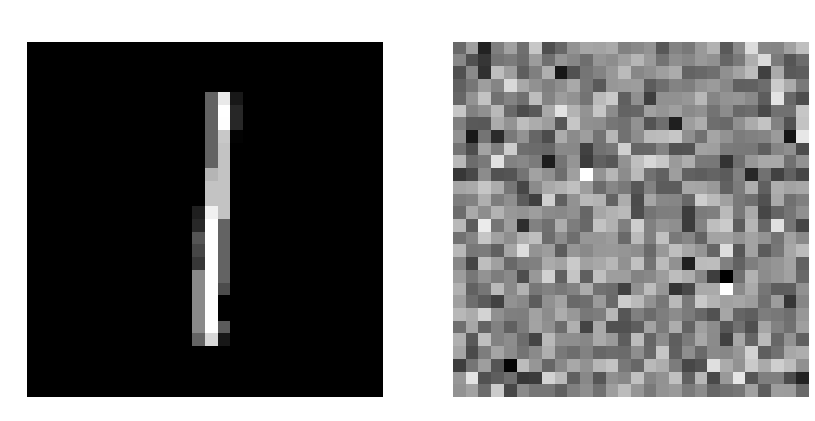

In [10]:
random_result()

In [19]:
def plot_img(img):
    img = img.reshape((28,28))
    plt.figure(figsize=(6,6))
    plt.imshow(img,cmap='gray')
    plt.show()

In [ ]:
img = X_test[0]
img.shape

In [ ]:
plot_img(img)

In [ ]:
noisy_img = img * 255
noisy_img = img + np.random.normal(0.05,0.05,img.shape)
noisy_img = np.clip(noisy_img,0,255)
noisy_img = noisy_img /255
plot_img(noisy_img)

In [ ]:
noise_data = np.array([noisy_img])
noise_pred = autoencoder.predict(noise_data)

In [ ]:
plot_img(noise_pred[0])

## Series of images

In [ ]:
for epoch in range(1,EPOCHS+1):
    print(f'Loading Model for Epoch {epoch}')
    saved_model = load_model(os.path.join('saved_models','autoencoder-epoch_{}.h5'.format(epoch)))
    pred = saved_model.predict(X_test)
    img = pred[0].reshape((28,28))
    plt.imshow(img,cmap='gray')
    plt.savefig('images\epoch-{}.png'.format(epoch),dpi=200)
    plt.close()
    #cv2.imwrite('images\epoch-{}.png'.format(epoch),img)
    print(f'image {epoch} saved.')
    del saved_model

Loading Model for Epoch 1
image 1 saved.
Loading Model for Epoch 2
image 2 saved.
Loading Model for Epoch 3
image 3 saved.
Loading Model for Epoch 4
image 4 saved.
Loading Model for Epoch 5
image 5 saved.
Loading Model for Epoch 6
image 6 saved.
Loading Model for Epoch 7
image 7 saved.
Loading Model for Epoch 8
image 8 saved.
Loading Model for Epoch 9
image 9 saved.
Loading Model for Epoch 10
image 10 saved.
Loading Model for Epoch 11
image 11 saved.
Loading Model for Epoch 12
image 12 saved.
Loading Model for Epoch 13
image 13 saved.
Loading Model for Epoch 14
image 14 saved.
Loading Model for Epoch 15
image 15 saved.
Loading Model for Epoch 16
image 16 saved.
Loading Model for Epoch 17
